# Heart disease
This notebook builds a hierarchical ayesian for predicting whether a patient suffers from heart disease. The dataset is collected from https://www.kaggle.com/ronitf/heart-disease-uci.

To build the model the package PYMC3 is used with Variational inference. First off, lets import the data and explore it. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import data
import theano
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn')
np.random.seed(1)
train, test = data.load_train_and_test(frac_test=.2)
train_x, train_y = train

## Continuous features

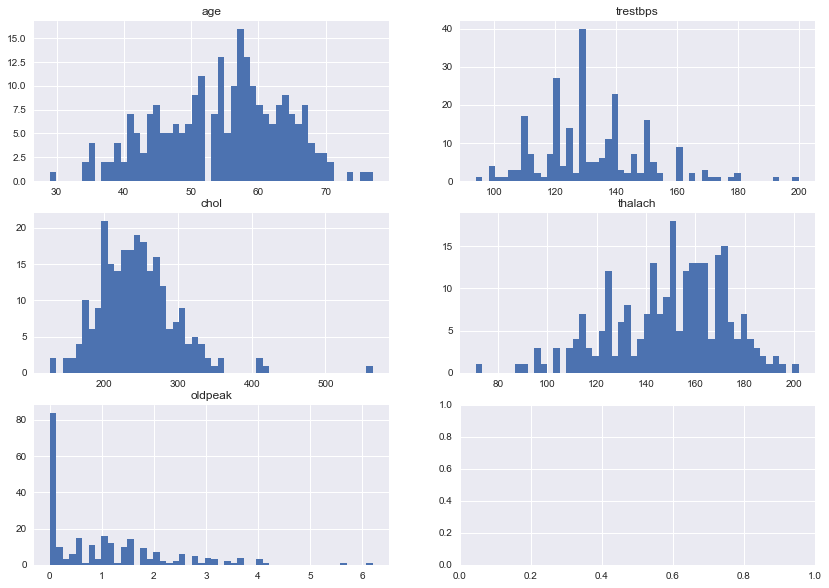

In [2]:
real_valued_features = [
  'age', 'trestbps', 'chol',
  'thalach', 'oldpeak'
]

_, axs = plt.subplots(3, 2, figsize=(14, 10))
for ax, f in zip(axs.flatten(), real_valued_features):
    ax.hist(train_x[f], bins=50)
    ax.set_title(f)

#train_x.groupby('chol').size().sort_values().plot(kind='hist', ax=ax)

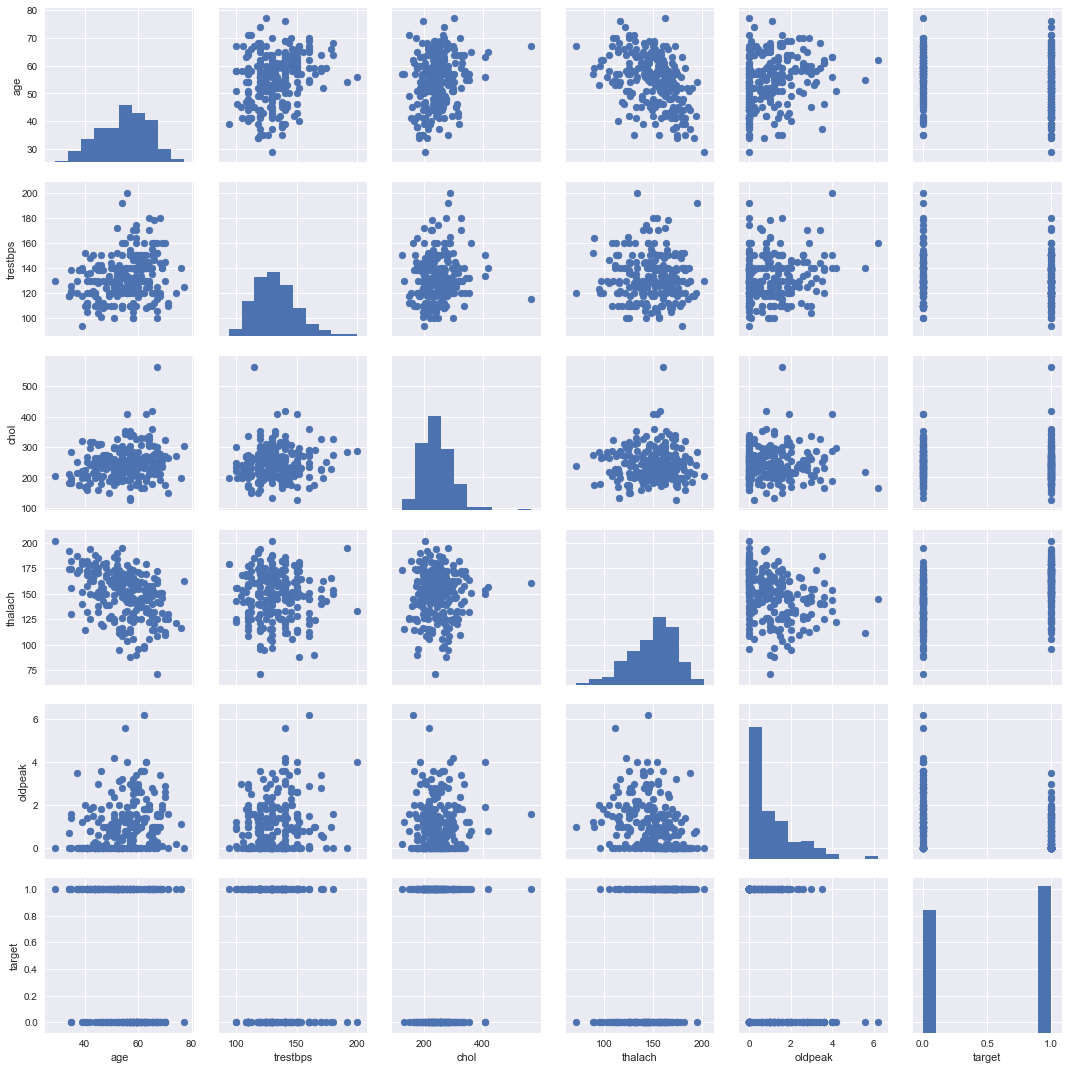

In [5]:
grid = sns.PairGrid(train_x[real_valued_features].join(train_y))
grid.map_upper(plt.scatter)
grid.map_lower(plt.scatter)
grid.map_diag(plt.hist)

## Discrete features

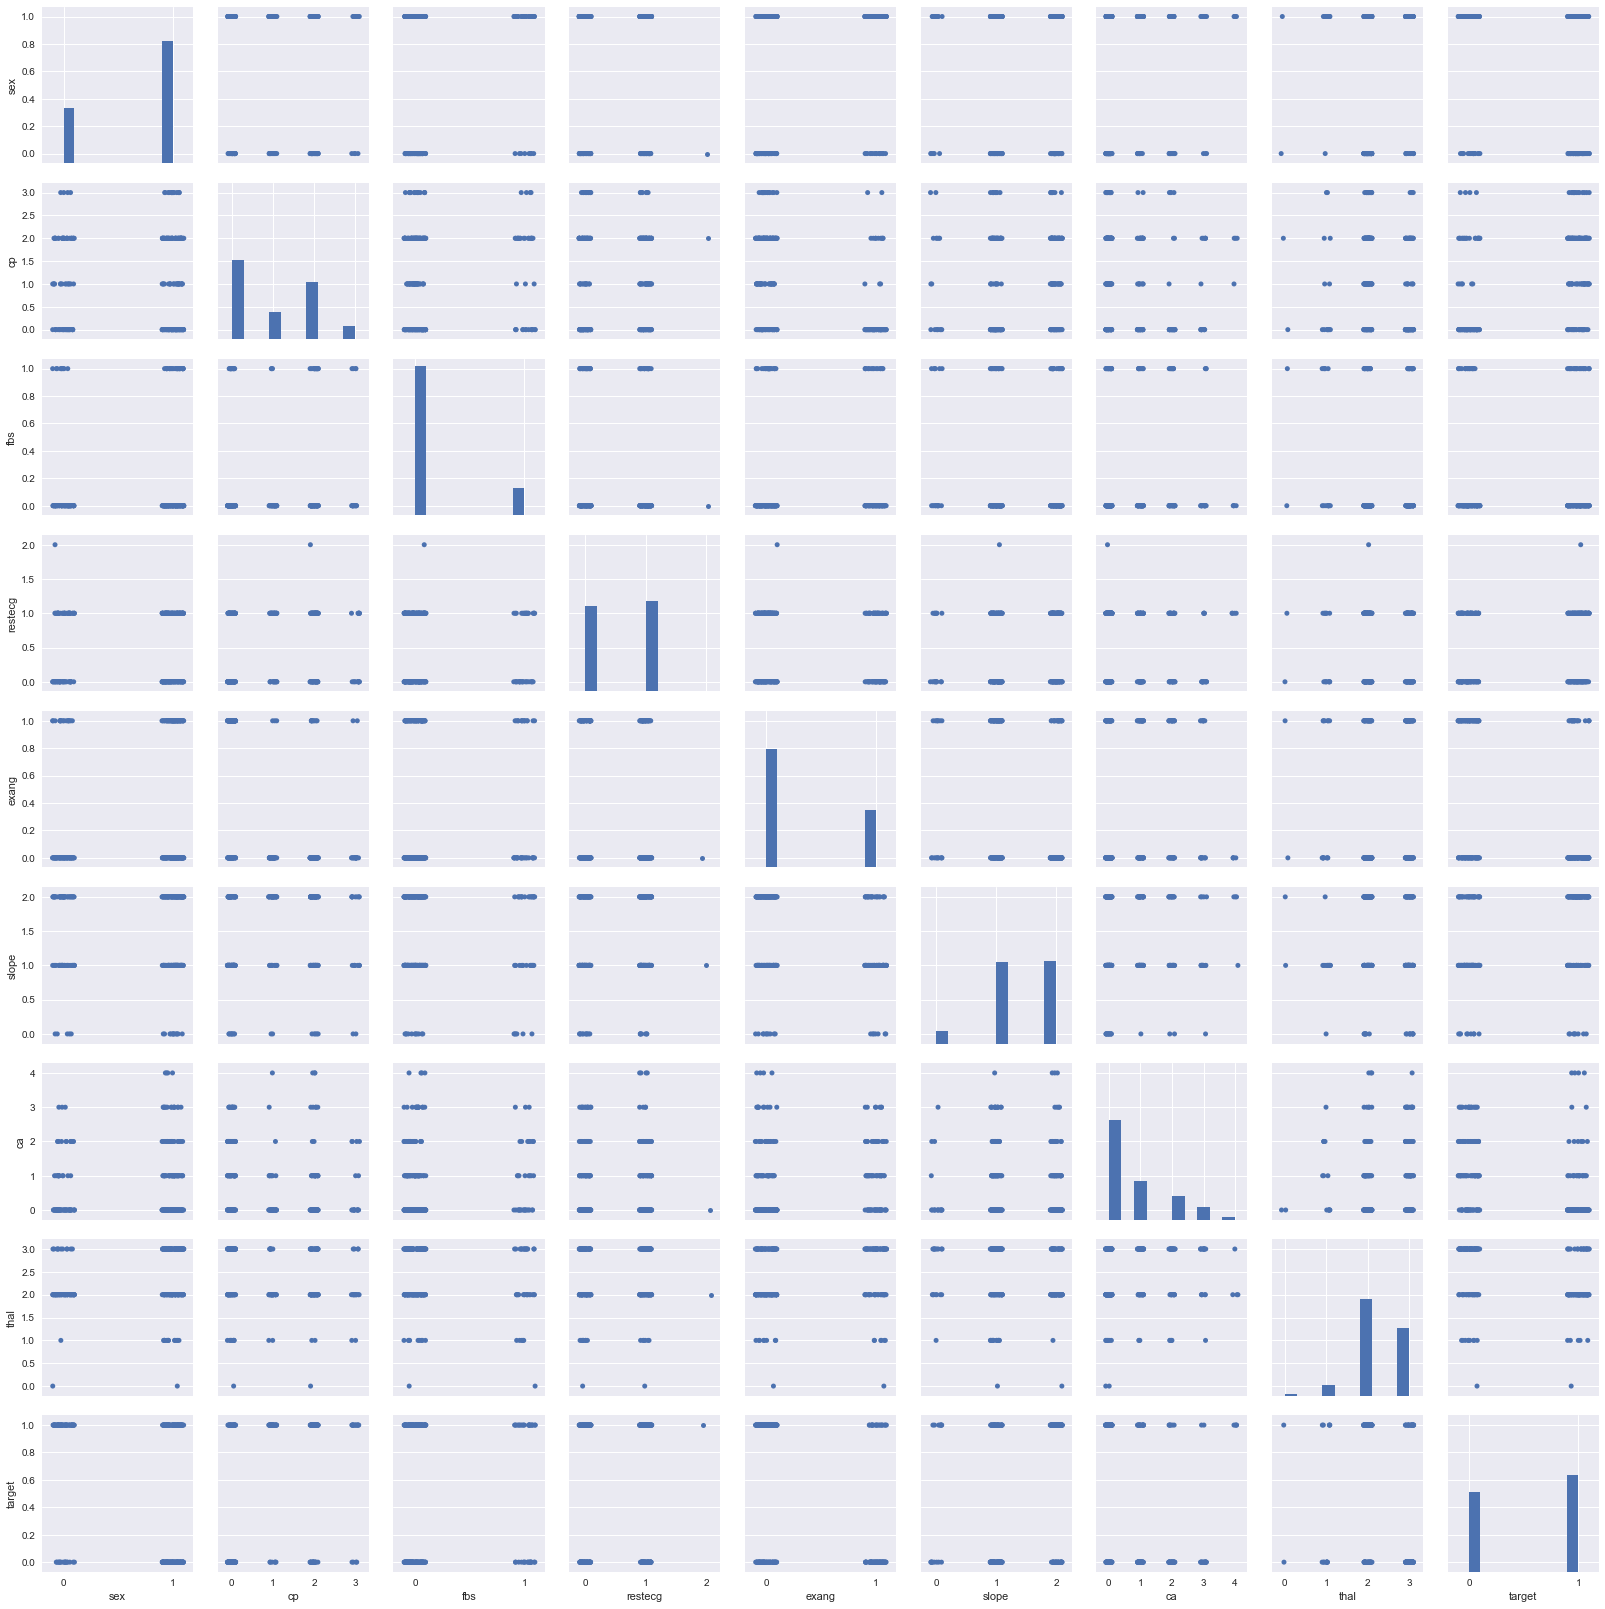

In [26]:
grid = sns.PairGrid(train_x.drop(real_valued_features, axis=1).join(train_y))

grid.map_upper(sns.stripplot, jitter=True)
grid.map_lower(sns.stripplot, jitter=True)
grid.map_diag(plt.hist)

No features seem to be increadibly correlated. Let's use all of them with Laplace priors to make variabel selection. But first lets normalise the data. 

In [6]:
def new_scaler(cov): 
    scaler = StandardScaler()
    scaler.fit(train_x[cov].values.reshape(-1, 1))
    return scaler

scalers = {
  cov: new_scaler(cov)
  for cov in real_valued_features
}

scaler = StandardScaler()
rvcs = scaler.fit_transform(train_x[real_valued_features].values)

The model that we're bulding is defined as 
$

In [20]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as T

# Continuous features
X = theano.shared(rvcs)
y = theano.shared(train_y.values)

# Categorical features
sex = theano.shared(train_x.sex.values)
cp = theano.shared(train_x.cp.values)
fbs = theano.shared(train_x.fbs.values)
ca = theano.shared(train_x.ca.values)
thal = theano.shared(train_x.thal.values)
exang = theano.shared(train_x.exang.values)
n_features = theano.shared(rvcs.shape[1])

with pm.Model() as heart_model:

    n_sexs = len(np.unique(sex.get_value()))
    n_cps = len(np.unique(cp.get_value()))
    n_fbs = len(np.unique(fbs.get_value()))
    n_exangs = len(np.unique(exang.get_value()))
    n_cas = len(np.unique(ca.get_value()))
    n_thals = len(np.unique(thal.get_value()))
    shape = n_sexs, n_cps, n_fbs, n_thals, n_cas, n_exangs
    #index = sex.get_value(), cp.get_value(), fbs.get_value(), thal.get_value(), ca.get_value(), exang.get_value()
    #mu_alphas = [pm.Normal(f'mu_alpha{i}', mu=0, sd=10) for i in range(n_cats)]
    #mu_betas = [pm.Normal(f'mu_beta{i}', mu=0, sd=10) for i in range(n_cats)]

    mu_b0 = pm.Normal('mu_b0', mu=0, sd=1)
    sigma_b0 = pm.HalfNormal('sigma_b0', sd=1)
    #mu_beta = pm.Normal('mu_beta', mu=0, sd=10)
    #sigma_beta = pm.HalfNormal('sigma_beta', sd=10)
    #b0_off = 
    b0 = pm.Normal('b0', mu=mu_b0, sd=sigma_b0)
    #pm.Deterministic('b0', mu_b0 + b0_off * sigma_b0)
    #pm.Normal('b0', mu=mu_b0, sd=sigma_b0)
    #sex_b = pm.Normal('sex_b', mu=mu_beta, sd=sigma_beta, shape=2)
    ca_b = pm.Normal('ca_b', mu=0, sd=10)
    fbs_b = pm.Normal('fbs_b', mu=0, sd=10)
    exang_b = pm.Normal('exang_b', mu=0, sd=10)
    #alpha = pm.Deterministic('alpha', mu_alpha + alpha_off * sigma_alpha)
    #beta = pm.Deterministic('beta', mu_beta + beta_off * sigma_beta)

    z = (
        b0 
        + sex_b[sex] * sex
        #+ ca_b * ca
        #+ fbs_b * fbs
        #+ exang_b * exang
    )
    p = pm.math.sigmoid(z) # Bernoulli inverse link function
    heart = pm.Bernoulli('heart', p=p, observed=y)

    #trace = pm.sample(5000, tune=4000, target_accept=.9)

    trace = pm.sample(1000, tune=2000, target_accept=.8)

#trace = approx.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [exang_b, fbs_b, ca_b, b0, sigma_b0, mu_b0]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 16000/16000 [00:11<00:00, 1420.91draws/s]
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


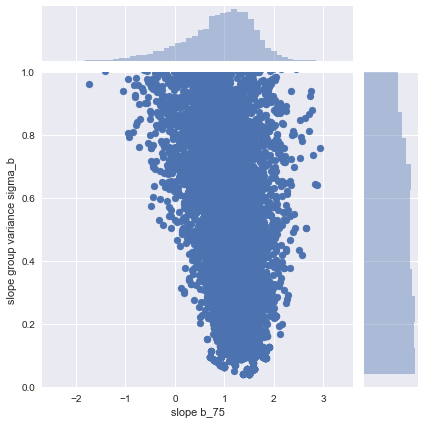

In [22]:
x = pd.Series(trace['mu_b0'], name='slope b_75')
y = pd.Series(trace['sigma_b0'], name='slope group variance sigma_b')

sns.jointplot(x, y, ylim=(0, 1));

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B397719358>,
      dtype=object)

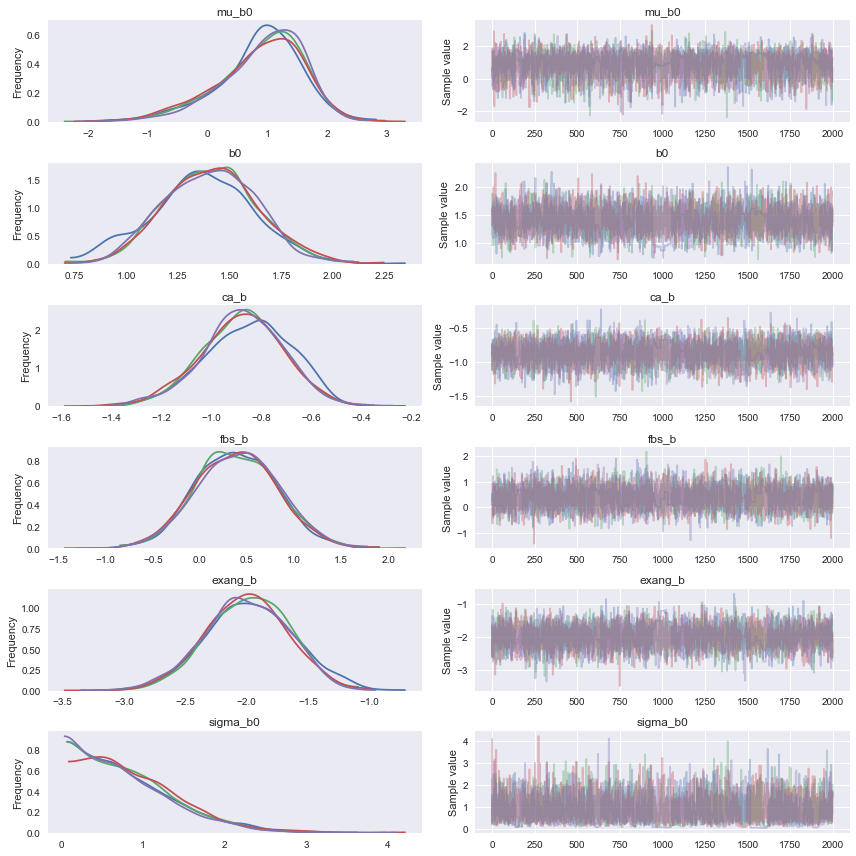

In [23]:
pm.traceplot(trace)

## Sample posterior

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.97it/s]


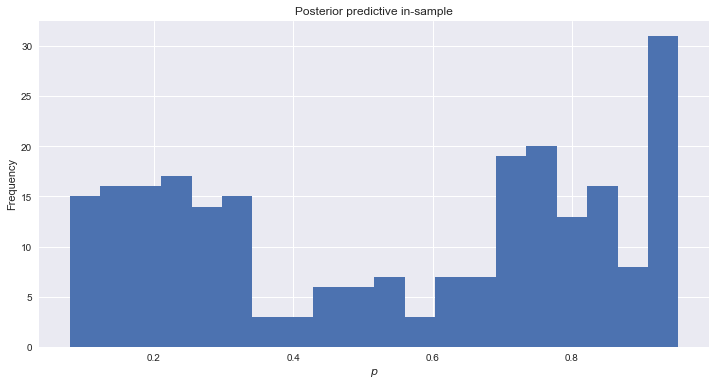

In [19]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(12, 6))
n_samples = 1000
ppc = pm.sample_posterior_predictive(trace, samples=n_samples, model=heart_model)
p = ppc['heart'].mean(axis=0)
ax.hist(p, bins=20)
ax.set(title='Posterior predictive in-sample', xlabel=r'$p$', ylabel='Frequency');

## Compute accuracy

In [20]:
pred = ppc['heart'].mean(axis=0) > .5
(pred == train_y).mean()

0.9421487603305785

In [24]:
heart_model

In [21]:
test_x, test_y = test

test_rvcs = scaler.transform(test_x[real_valued_features].values)
sex.set_value(test_x.sex.values)
cp.set_value(test_x.cp.values)
fbs.set_value(test_x.fbs.values)
ca.set_value(test_x.ca.values)
thal.set_value(test_x.thal.values)
exang.set_value(test_x.exang.values)
X.set_value(test_rvcs)
y.set_value(test_y.values)
n_features.set_value(test_rvcs.shape[1])
n_samples = 1000
test_ppc = pm.sample_posterior_predictive(trace, samples=n_samples, model=heart_model)
pred = test_ppc['heart'].mean(axis=0) > .5
(pred == test_y).mean()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\sebas\AppData\Roaming\Python\Python37\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])



ValueError: Input dimension mis-match. (input[0].shape[0] = 242, input[1].shape[0] = 61)
Apply node that caused the error: Elemwise{Mul}[(0, 0)](AdvancedSubtensor.0, <TensorType(float64, matrix)>)
Toposort index: 5
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(242, 5), (61, 5)]
Inputs strides: [(40, 8), (8, 488)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Sum{axis=[1], acc_dtype=float64}(Elemwise{Mul}[(0, 0)].0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [23]:
n_features.get_value()

array(5)